# Comparing train data segmention measurments to manual measurments

This notebook explores how well vein length measurements extracted from the the neural network segmentations of the training correlate with manual measurments

In [1]:
%qtconsole

In [2]:
import sys
import os
from os.path import join, basename
from pathlib import Path
import matplotlib.pyplot as plt

project_root = os.path.abspath('../')

## Get The Measurments
The segmentations were first perfomed by calling:

```bash
make models/v3/results/dilations/train/
```

Then the vein lengths were extraced and saved to reports/v3/data/results.sqlite using:

```bash
make v3_results
```

Manual measruments were added to teh databse using:

```bash
make manual_measurments
```

So we will open a connection to that database here

In [3]:
import dataset
db = dataset.connect('sqlite:///../reports/v3/data/results.sqlite')

## Plot the results

In [4]:
import pandas as pd
import sqlite3
import warnings


conn = sqlite3.connect('../reports/data/results.sqlite')

df_test = pd.read_sql("SELECT * FROM v3_test_vein_length",conn)
df_1500_test = pd.read_sql("SELECT * FROM v3_1500_test_vein_length",conn)
df_human = pd.read_sql("SELECT * FROM manually_measured",conn)

def plot_scatter(df):
    if df[['length_measured','length_human']].any().any():
        warnings.warn("NA values detected, they will be dropped")
        df = df.dropna()

    #Plot Scatter data
    fig, ax = plt.subplots()
    plt.scatter(df['length_measured'],df['length_human'])
    plt.xlabel('AI Measured Vein Length (pixels)')
    plt.ylabel(r'Human Measured Vein Length ($\mu$m)')

    #Add correlation information
    r =  df[['length_measured','length_human']].corr()['length_measured'][1]
    plt.text(35000, 17500, r"$R^2$ = %1.5f"%(r**2,))
    
    return (fig,ax)

/home/cotter/.local/share/virtualenvs/burke_leaf_veins-yIOEQYw0/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: NA values detected, they will be dropped
  


Text(0.5, 1.0, 'Test 1500 Images')

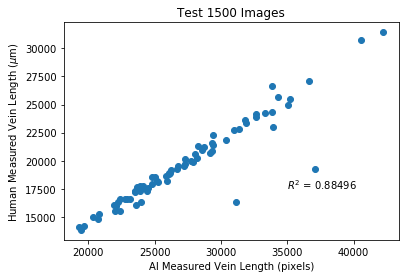

In [10]:
df_1500_test_merged = df_1500_test.merge(df_human[['plant','replicate','length']],
                       on=["plant","replicate"],
                       how="left",
                       suffixes=("_measured","_human"))

plot_scatter(df_1500_test_merged)
plt.title('Test 1500 Images')
#plt.savefig('CorrelationTrain.png',dpi=300)

/home/cotter/.local/share/virtualenvs/burke_leaf_veins-yIOEQYw0/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: NA values detected, they will be dropped
  


Text(0.5, 1.0, 'Test Images')

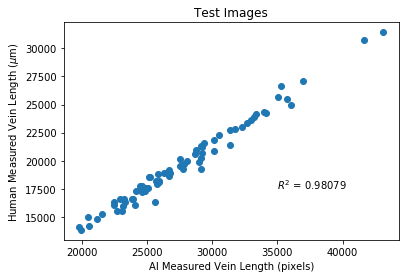

In [11]:
df_test_merged = df_test.merge(df_human[['plant','replicate','length']],
                       on=["plant","replicate"],
                       how="left",
                       suffixes=("_measured","_human"))

plot_scatter(df_test_merged)
plt.title('Test Images')
#plt.savefig('CorrelationTest.png',dpi=300)

In [15]:
import numpy as np

error = df_1500_test_merged['length_measured'] - df_1500_test_merged['length_human']
error = error - error.mean()
std = np.std(error)

outliers_idx = np.where(error**2 > (std**2 * 3))

print(r"Outliers with an error greater than %0.0f:"%(std * 3,))
outliers = df_1500_test_merged.iloc[outliers_idx].copy()
outliers['error'] = error.iloc[outliers_idx]
outliers[['plant','replicate','length_measured','length_human','error']]

Outliers with an error greater than 5802:


,plant,replicate,length_measured,length_human,error
67,901,3,37098,19227.029,10253.329081
69,902,3,31154,16302.050,7234.308081


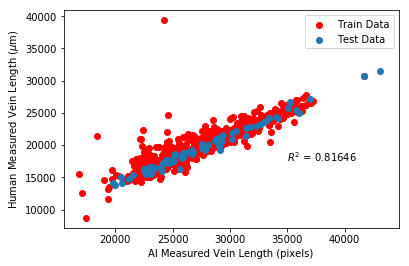

In [96]:
df_all_merged = pd.concat([df_test_merged, df_train_merged])
df_all_merged = df_all_merged.dropna()

fig, ax = plt.subplots()
plt.scatter(df_train_merged['length_measured'],
            df_train_merged['length_human'],
            c='r',
            label="Train Data")
plt.scatter(df_test_merged['length_measured'],
            df_test_merged['length_human'],
            label="Test Data")
plt.xlabel('AI Measured Vein Length (pixels)')
plt.ylabel(r'Human Measured Vein Length ($\mu$m)')

r =  df_all_merged[['length_measured','length_human']].corr()['length_measured'][1]
plt.text(35000, 17500, r"$R^2$ = %1.5f"%(r**2,))
ax.legend()
plt.savefig('CorrelationTrainTest.png',dpi=300)

## Explore the model error

Histogram of the errors between the human measured and predicted vein length.

$$ error_i = (x_i-y_i) - \frac{1}{N} \sum_{i=1}^{N} (x_i - y_i) $$

where $x_i$ is the human measured vein length and $y_i$ is the AI measured vein length for sample $i$. 

__Note that the standard deviation and error have no useful units.__ 

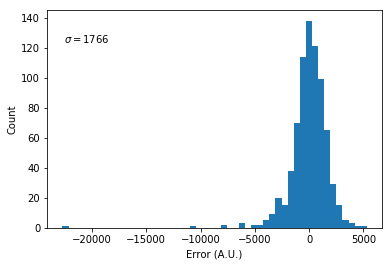

In [116]:
import numpy as np

error = df_all_merged['length_measured'] - df_all_merged['length_human']
error = error - error.mean()

plt.hist(error,50);
plt.xlabel(r'Error (A.U.)')
plt.ylabel('Count')

std = np.std(error)
plt.annotate(r"$\sigma = %0.0f$"%(std,), 
             xy=(0.05, 0.85), 
             xycoords='axes fraction');

## Poorly segmented images

- I defined outliers as measured predictions that were off from the manually measured by more than $3\sigma$ 
- The table naming scheme from the image file names is [plant]-[replicate].jpg

In [117]:
outliers_idx = np.where(error**2 > (std**2 * 3))

print(r"Outliers with an error greater than %0.0f:"%(std * 3,))
outliers = df_all_merged.iloc[outliers_idx].copy()
outliers['error'] = error.iloc[outliers_idx]
outliers[['plant','replicate','length_measured','length_human','error']]

Outliers with an error greater than 5298:


,plant,replicate,length_measured,length_human,error
31,217,1,41672,30729.113,3320.771336
32,217,2,43132,31431.448,4078.436336
36,226,1,36027,24966.249,3438.635336
4,100,2,22980,18471.186,-3113.301664
9,102,7,22254,17960.293,-3328.408664
10,102,8,18389,21384.907,-10618.022664
11,103,7,22940,19570.351,-4252.466664
32,111,2,24523,20528.329,-3627.444664
44,117,1,22135,17965.391,-3452.506664
75,13,2,19744,16136.966,-4015.081664


## Fit a linear model to the data to find outliers.

To get an idea of how much the error is in micrometers, I fit a linear model to the data and used it to convert AI measured vein length to micromenters.

<IPython.core.display.Latex object>

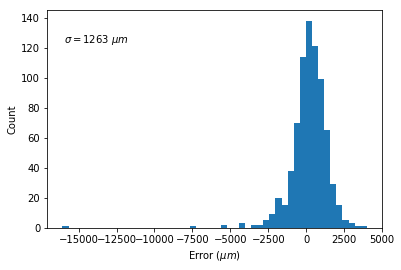

In [129]:
from sklearn.linear_model import LinearRegression
from IPython.display import display, Latex

reg = LinearRegression().fit(df_all_merged['length_measured'].values.reshape(-1,1),
                           df_all_merged['length_human'])

display(Latex(r"Model estimated $%0.1f$ $pixels/ \mu m$"%(reg.intercept_)))

preds = reg.predict(error.values.reshape(-1,1))

plt.hist(preds,50);
plt.xlabel(r'Error ($\mu m$)')
plt.ylabel('Count')

std = np.std(preds)
plt.annotate(r"$\sigma = %0.0f$ $\mu m$"%(std,), 
             xy=(0.05, 0.85), 
             xycoords='axes fraction');